<a href="https://colab.research.google.com/github/robbieheriot/Texture-Generation-GAN/blob/main/GANtextures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [ ]:
#import tensorflow which is a deep learning library
import tensorflow as tf
#import keras which is part of tensorflow and has pre-built layers for neural networks
from tensorflow.keras import layers
#import InceptionV3 is a pre trained model which is used for calculating the FID and IS
from tensorflow.keras.applications.inception_v3 import InceptionV3
#import pillow which is used to load and resize images
from PIL import Image
#import os which is used to interact with files
import os
#import glob which is used to help sort files
import glob
#import numpy to handle arrays and mathematical operations
import numpy as np
# import scipy for finding the square root of a matrix (FID calculation)
from scipy.linalg import sqrtm
#sklearn used to slpit the mode into training and testing batches
from sklearn.model_selection import train_test_split

# Define the Inception model for FID and IS
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Function to resize images to 299x299
def resize_images(images, size=(299, 299)):
    return tf.image.resize(images, size)

# Function to calculate FID
def calculate_fid(model, images1, images2):

  # Resize both image sets
    images1 = resize_images(images1)
    images2 = resize_images(images2)

    # Get feature activations from the model for both image sets
    act1 = model.predict(images1)
    act2 = model.predict(images2)

   # Calculate mean and covariance for the activations of both image sets
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Compute the sum of squared differences between the means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # Compute the square root of the product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle complex values that might arise during the sqrt computation
    if np.iscomplexobj(covmean):
        covmean = covmean.real

     # Compute the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to calculate IS
def calculate_is(model, images, eps=1E-16):
    # Resize input images
    images = resize_images(images)
    # Get the model's predictions
    preds = model.predict(images)
    # Convert the predictions into probabilities
    probs = np.exp(preds) / np.sum(np.exp(preds), axis=0)
    # Compute the KL divergence between the probabilities and their means
    kl = probs * (np.log(probs) - np.log(np.expand_dims(np.mean(probs, 0), 0)))
    # Sum over all images and take the mean
    kl = np.mean(np.sum(kl, 1))
    # Compute the Inception Score
    is_score = np.exp(kl)
    return is_score

 # Set paths to files
input_dir = '/content/textures'
output_dir = '/content/gantextures'
#if theres not output file make one
os.makedirs(output_dir, exist_ok=True)

# make an list called images
images = []

#loop through the input file,and select only jppgs
for image_path in glob.glob(os.path.join(input_dir, '*.jpg')):
    #returns the image as an image object
    image = Image.open(image_path)
    #resizes it to 512x512
    image = image.resize((512, 512))
    #adds image to list
    images.append(np.array(image))


train_images, test_images = train_test_split(images, test_size=0.2, random_state=42) # 80% train, 20% test



# Convert train and test image lists to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
# Normalize images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

# Define constants for buffering and batching the dataset
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 32

# Convert the images into a TensorFlow dataset, shuffle and batch them
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



def make_generator_model():
    # Initialize a sequential model for the generator
    model = tf.keras.Sequential()

    # Add a densely connected layer with no biases, suitable for the input shape
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # Add a batch normalization layer to normalize the activations
    model.add(layers.BatchNormalization())
    # Use leaky ReLU as an activation function
    model.add(layers.LeakyReLU())

    # Reshape the 1D tensor to a 3D tensor to get ready for convolutional layers
    model.add(layers.Reshape((8, 8, 256)))
    # Ensure the tensor has the correct shape
    assert model.output_shape == (None, 8, 8, 256)


    # The following blocks will upscale the image and refine its features
    # First, upsample the image to double its dimensions
    model.add(layers.UpSampling2D())
    # Add a convolutional layer
    model.add(layers.Conv2D(128, (5, 5), padding='same', use_bias=False))
    # Ensure the tensor has the correct shape
    assert model.output_shape == (None, 16, 16, 128)
    # Normalize activations and use leaky ReLU
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Continue the process of upsampling and refining
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(32, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(16, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(8, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final block: upscale and produce the output image with 3 channels (RGB)
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(3, (5, 5), padding='same', use_bias=False, activation='tanh'))
    # Ensure the tensor has the correct shape of the final output
    assert model.output_shape == (None, 512, 512, 3)

    return model

def make_discriminator_model():
    # Initialize a sequential model for the discriminator
    model = tf.keras.Sequential()

    # Begin with convolutional layer, downsample the input image
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[512, 512, 3]))
    # Use leaky ReLU activation
    model.add(layers.LeakyReLU())
    # Add a dropout layer to reduce overfitting
    model.add(layers.Dropout(0.3))

    # Continue refining and downsampling the image
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the 3D tensor into a 1D tensor to make it suitable for a dense layer
    model.add(layers.Flatten())
    # Add a dense layer with a single neuron to output the prediction
    model.add(layers.Dense(1))

    return model



# Use Binary Cross-Entropy as the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):

    # Calculate the loss for classifying real images as real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Calculate the loss for classifying fake images as fake
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Combine both losses
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):

      # Calculate the generator's loss based on how well the discriminator was fooled
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Use Adam optimizer for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Instantiate both generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()



# Define a function to train both the models in one step.
@tf.function
def train_step(images):
    # Generate random noise for each image in the batch
    noise = tf.random.normal([BATCH_SIZE, 100])

    # Open gradient tape for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from the noise using the generator
        generated_images = generator(noise, training=True)

        # Get discriminator's prediction on real images
        real_output = discriminator(images, training=True)
        # Get discriminator's prediction on fake (generated) images
        fake_output = discriminator(generated_images, training=True)

        # Calculate loss for the generator based on discriminator's predictions
        gen_loss = generator_loss(fake_output)
        # Calculate combined loss for discriminator for real and fake images
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the gradients for generator based on its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Calculate the gradients for discriminator based on its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to update generator's weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Apply the gradients to update discriminator's weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    # Use the generator model to produce images from the input noise
    predictions = model(test_input, training=False)
    # Convert the pixel values from [-1,1] to [0,255] for saving as PNG
    predictions = (predictions + 1) * 127.5

    # Loop over each generated image in the batch
    for i in range(predictions.shape[0]):
        # Convert the array data into an image
        im = Image.fromarray(predictions[i].numpy().astype(np.uint8))
        # Save each image with the current epoch number in its name
        im.save(f'{output_dir}/image_at_epoch_{epoch:04d}.png')



# Generate a fixed set of random noise values for consistent image generation during training
seed = tf.random.normal([5, 100])

def train(dataset, epochs):
    # Loop through each epoch up to the specified number of epochs
    for epoch in range(epochs):
        # Loop through each batch of images in the dataset
        for image_batch in dataset:
            # Update the generator and discriminator based on the current batch of images
            train_step(image_batch)

        # Every 500 epochs, do the following:
        if (epoch + 1) % 500 == 0:
            # Generate and save images using the generator and the fixed noise seed
            generate_and_save_images(generator, epoch + 1, seed)

            # Generate images from the fixed seed for FID and IS calculation
            generated_images = generator(seed, training=False)
            # Calculate the FID between generated images and the last batch of real images
            fid = calculate_fid(inception_model, generated_images, test_images[:len(generated_images)])
            # Calculate the IS for the generated images
            is_score = calculate_is(inception_model, generated_images, test_images[:len(generated_images)])

            # Print the FID and IS scores
            print('FID: ', fid)
            print('IS: ', is_score)

# Set the number of epochs for training
EPOCHS = 25000
# Start training the models for the specified number of epochs
train(train_dataset, EPOCHS)


#Download Textures

In [ ]:
!zip -r /content/gantextures.zip /content/gantextures/

In [ ]:
from google.colab import files
files.download("/content/gantextures.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Visulize Evaluation Metrics

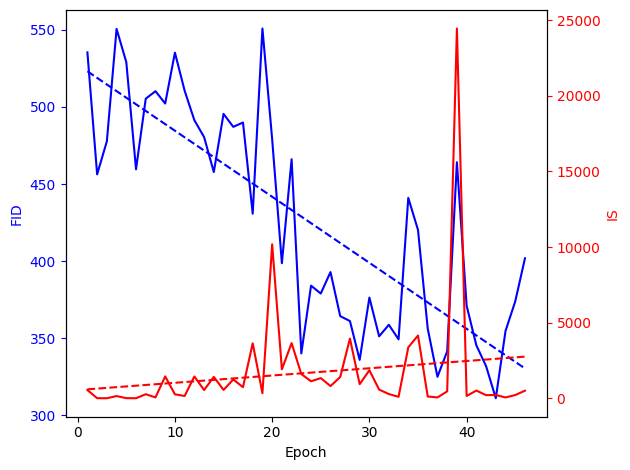

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# the data


FID_scores= [535.3702719716232, 456.28338352219475, 477.70988339505186, 550.5871924760917, 529.018051456475, 459.5930719085585, 505.3543272938963, 510.20323968649586, 502.21946493111466, 535.1990078590004, 510.5099321074732, 491.4042065493642, 480.47899259615485, 457.77499085410886, 495.50114577244744, 487.08699206134327, 489.8847599098071, 430.78641774253697, 550.8651670704807, 479.12888350403625, 398.68258611564374, 466.0724012919979, 340.2069591947726, 384.11043253314153, 379.0158395585662, 392.93670535444835, 364.3543405187994, 361.17990465370576, 335.99394065052326, 376.39603563495854, 351.2776953050253, 358.7362888480286, 349.32333634463396, 441.04132343792014, 420.23539154381666, 356.25016915898044, 325.0019007782595, 341.57042198159075, 464.14920046336454, 371.11643410375325, 345.4441101308632, 331.9630185171419, 311.12964065278953, 354.7492206989279, 373.94649199077617, 401.8549057484166]

IS_scores= [554.6593, 15.201224, 12.343563, 156.01103, 17.723984, 13.478296, 277.85806, 68.29314, 1454.5454, 270.15622, 161.58658, 1450.3843, 554.09045, 1423.5079, 561.5907, 1252.9153, 743.2323, 3642.1548, 344.08377, 10183.948, 1924.1638, 3653.7676, 1610.3921, 1132.838, 1342.834, 815.5881, 1416.1299, 3954.3547, 940.70416, 1861.661, 582.95984, 288.14798, 106.50845, 3376.0967, 4156.937, 127.05974, 64.898865, 465.67078, 24447.27, 162.93507, 520.70746, 214.9682, 226.55418, 64.23447, 222.38623, 512.73663]

epochs = list(range(1,len(FID_scores)+1))

# Fit a trendline to the data
z1 = np.polyfit(epochs, FID_scores, 1)
p1 = np.poly1d(z1)

z2 = np.polyfit(epochs, IS_scores, 1)
p2 = np.poly1d(z2)

# Create the figure and the axes
fig, ax1 = plt.subplots()

# Plot FID scores and its trend line
ax1.plot(epochs, FID_scores, 'b-', epochs, p1(epochs), "b--")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('FID', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for the IS scores and its trend line
ax2 = ax1.twinx()
ax2.plot(epochs, IS_scores, 'r-', epochs, p2(epochs), "r--")
ax2.set_ylabel('IS', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()


